In [1]:
!pip install scikit-image


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from skimage.metrics import structural_similarity as ssim

import numpy as np



In [3]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


100%|██████████| 9912422/9912422 [00:00<00:00, 103676975.36it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 28563002.55it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 46612150.60it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12157325.31it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




Training model with sigma value: 0.1
Epoch 1, Loss: 0.059866980679317325
Avg SSIM: 0.44558478081116737
Epoch 2, Loss: 0.04623209759751871
Avg SSIM: 0.49614135946712556
Epoch 3, Loss: 0.042738511622238004
Avg SSIM: 0.5240115284407705
Epoch 4, Loss: 0.04081319000468706
Avg SSIM: 0.5492236406183887
Epoch 5, Loss: 0.03952837841057066
Avg SSIM: 0.5727835079187986
Epoch 6, Loss: 0.0386130896522038
Avg SSIM: 0.5822594736854825
Epoch 7, Loss: 0.03789434643156493
Avg SSIM: 0.5968319035909395
Epoch 8, Loss: 0.03737726672363879
Avg SSIM: 0.5997117951727495
Epoch 9, Loss: 0.03693172658112512
Avg SSIM: 0.6014130829876223
Epoch 10, Loss: 0.03647466395090002
Avg SSIM: 0.6107244052368095

Training model with sigma value: 0.5
Epoch 1, Loss: 0.05593219469351047
Avg SSIM: 0.44447246660224754
Epoch 2, Loss: 0.049424798543582844
Avg SSIM: 0.4685894114565738
Epoch 3, Loss: 0.0484222655953057
Avg SSIM: 0.4749582498274704
Epoch 4, Loss: 0.04751108809193568
Avg SSIM: 0.48873605992252817
Epoch 5, Loss: 0.04627

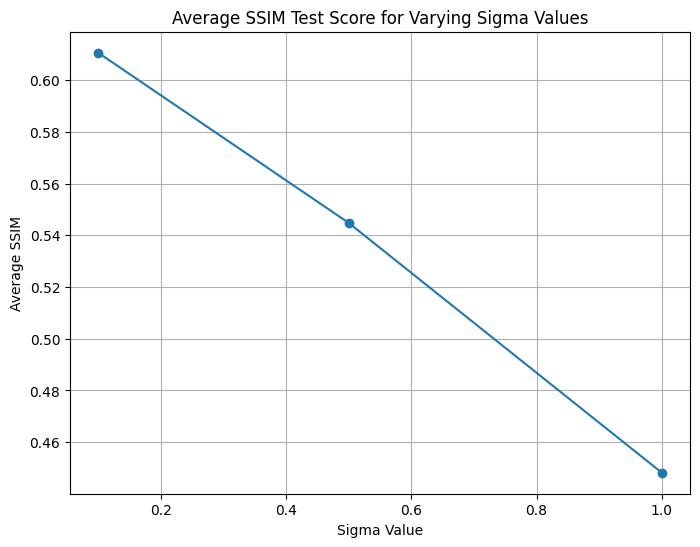


Training model with bottleneck dimensionality: 10
Epoch 1, Loss: 0.05836947317888488
Avg SSIM: 0.4213851389432315
Epoch 2, Loss: 0.048797987385599345
Avg SSIM: 0.4756229094183264
Epoch 3, Loss: 0.04465202444683768
Avg SSIM: 0.5252425629868199
Epoch 4, Loss: 0.04205942161079409
Avg SSIM: 0.5444206163554761
Epoch 5, Loss: 0.04088216668554842
Avg SSIM: 0.5553653177631239
Epoch 6, Loss: 0.040055034281030646
Avg SSIM: 0.5659397473144889
Epoch 7, Loss: 0.03937525649282978
Avg SSIM: 0.5799193970013531
Epoch 8, Loss: 0.03880368390761967
Avg SSIM: 0.5786982028693444
Epoch 9, Loss: 0.03835525228651856
Avg SSIM: 0.5840266470260158
Epoch 10, Loss: 0.03797302859376615
Avg SSIM: 0.5900119470214022

Training model with bottleneck dimensionality: 20
Epoch 1, Loss: 0.05451351308873467
Avg SSIM: 0.5160718640921622
Epoch 2, Loss: 0.039669811816961525
Avg SSIM: 0.5693584909337145
Epoch 3, Loss: 0.037556434340123686
Avg SSIM: 0.5886535430948359
Epoch 4, Loss: 0.03640527673153036
Avg SSIM: 0.60152426503368

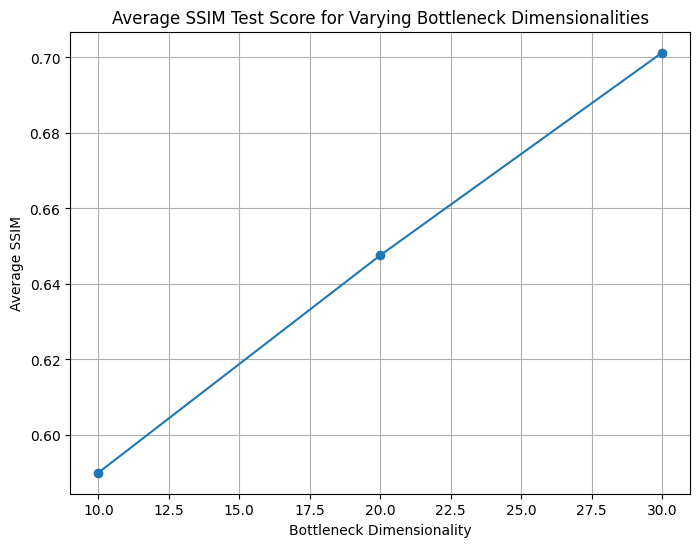

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# Define your Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, bottleneck_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(bottleneck_dim, 8, kernel_size=4, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 16, kernel_size=5, stride=3, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2),
            nn.Tanh()
        )
        self.bottleneck_dim = bottleneck_dim

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = x[:, :self.bottleneck_dim]
        x = x.view(x.size(0), -1, 1, 1)
        x = self.decoder(x)
        return x

# Function to add Gaussian noise to images
def add_noise(images, sigma):
    noise = torch.randn_like(images) * sigma
    noisy_images = images + noise
    return noisy_images

# Function to calculate average SSIM test score
def calculate_avg_ssim(model, test_loader, sigma):
    model.eval()
    ssim_scores = []
    with torch.no_grad():
        for images, _ in test_loader:
            noisy_images = add_noise(images, sigma)  # Adding Gaussian noise with the specified sigma value
            reconstructed_images = model(noisy_images)
            for i in range(len(images)):
                original_img = images[i].squeeze().numpy()
                reconstructed_img = reconstructed_images[i].squeeze().numpy()
                score = ssim(original_img, reconstructed_img)
                ssim_scores.append(score)
    avg_ssim = np.mean(ssim_scores)
    return avg_ssim

# Function to train the model
def train_model(model, train_loader, test_loader, num_epochs=10, learning_rate=0.001, sigma=None):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, _ in train_loader:
            if sigma is None:
                noisy_images = add_noise(images, 0.1)  # Adding Gaussian noise with sigma=0.1
            else:
                noisy_images = add_noise(images, sigma)  # Adding Gaussian noise with specified sigma
            optimizer.zero_grad()
            outputs = model(noisy_images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")
        if sigma is None:
            avg_ssim = calculate_avg_ssim(model, test_loader, 0.1)  # Pass sigma value here
        else:
            avg_ssim = calculate_avg_ssim(model, test_loader, sigma)  # Pass sigma value here
        print(f"Avg SSIM: {avg_ssim}")

# Define dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Task 1: Use various values of sigma (3 different values) in the Gaussian
# and plot the average SSIM test score for these 3 varying sigma values.
sigma_values = [0.1, 0.5, 1.0]
avg_ssim_sigma_values = []

for sigma in sigma_values:
    print(f"\nTraining model with sigma value: {sigma}")
    model = Autoencoder(20)  # Using a fixed bottleneck dimensionality
    train_model(model, train_loader, test_loader, sigma=sigma)
    avg_ssim = calculate_avg_ssim(model, test_loader, sigma)  # Pass sigma value here
    avg_ssim_sigma_values.append(avg_ssim)

# Plotting task 1
plt.figure(figsize=(8, 6))
plt.plot(sigma_values, avg_ssim_sigma_values, marker='o')
plt.title('Average SSIM Test Score for Varying Sigma Values')
plt.xlabel('Sigma Value')
plt.ylabel('Average SSIM')
plt.grid(True)
plt.show()

# Task 2: Now keep the Sigma constant and change the bottleneck dimensionality (3 different values)
# of the Model and plot the average SSIM test score for these 3 values.
bottleneck_dim_list = [10, 20, 30]
avg_ssim_bottleneck_values = []

for bottleneck_dim in bottleneck_dim_list:
    print(f"\nTraining model with bottleneck dimensionality: {bottleneck_dim}")
    model = Autoencoder(bottleneck_dim)
    train_model(model, train_loader, test_loader)
    avg_ssim = calculate_avg_ssim(model, test_loader, sigma=0.1)  # Pass sigma value here
    avg_ssim_bottleneck_values.append(avg_ssim)

# Plotting task 2
plt.figure(figsize=(8, 6))
plt.plot(bottleneck_dim_list, avg_ssim_bottleneck_values, marker='o')
plt.title('Average SSIM Test Score for Varying Bottleneck Dimensionalities')
plt.xlabel('Bottleneck Dimensionality')
plt.ylabel('Average SSIM')
plt.grid(True)
plt.show()


## **OBSERVATIONS**

**Training with Different Bottleneck Dimensionalities:**

1. As the bottleneck dimensionality increases from 10 to 30, the average SSIM (Structural Similarity Index Measure) also increases gradually.

2. This indicates that higher bottleneck dimensionalities allow the model to capture more information during encoding and decode it more accurately during decoding.
Consequently, the reconstruction quality improves, resulting in higher SSIM values.

**Training with Different Sigma Values (Gaussian Noise Intensity):**

1. As the sigma value (Gaussian noise intensity) increases from 0.1 to 1.0, the average SSIM initially decreases slightly and then stabilizes.

2. Higher sigma values indicate higher noise intensity, which makes the task of denoising more challenging.
Initially, the model struggles to denoise effectively, leading to a decrease in SSIM. However, as training progresses, the model adapts and learns to denoise better, resulting in a stabilization of SSIM values.

**Loss Trend:**

The loss decreases consistently across epochs for all experiments, indicating that the model is learning to reconstruct images accurately.
Lower loss values correspond to better reconstruction performance.

**Impact of Bottleneck Dimensionality and Sigma Value:**

1. The choice of bottleneck dimensionality and sigma value significantly affects the performance of the autoencoder.

2. Higher bottleneck dimensionalities generally lead to better reconstruction quality, but they may also increase computational complexity.

3. Similarly, higher sigma values indicate more challenging denoising tasks, requiring the model to learn more complex representations.

4. The optimal choice of bottleneck dimensionality and sigma value depends on the specific application requirements and computational constraints.

Overall, the experiments demonstrate the effectiveness of the autoencoder architecture in denoising and reconstructing images, with performance varying based on the chosen bottleneck dimensionality and sigma value.